# TimeSeries Forecasting @Datalift Conference Workshop in Berlin - Elia Group

created by the Center of Excellence AI Elia Group (Christian Merz, Thomas Craessaerts, Raphael Croegaert, Rachel Berryman)

Plan for the forecasting tool [graphic]

**Data**

    - Total Load
    - Pv production
    - Windproduction
    
**Additional Data**

    - weather data (wind speed, solar radiation, temperature)
    
**Forecast Options**

- univariate
- multivariate 

**User Interface**
- Select the data to forecast
- select the historical data 
- select the forecast horizon
- for multivariate: choose which additonal features to add


### Agenda ###
1. Exploring the data  
 1.1. Elia Open Data (Total Load, PV and Wind production)  
 1.2 Rebase API Weather Forecast  
 1.3 Quick Visualization of the Data  
1. Time Series forecasting with Prophet  
 2.1 Univariate Forecasting  
 2.2 Multivariate Forecasting  
3. Putting everything together in a Web App with Streamlit  


**Python Version**
- Python: 3.8.13
   
**Necessary libraries**
- pip install streamlit
- pip install pystan==2.19.1.1
- conda install prophet

###     1. Exploring the data from the Elia OpenData Platform


https://opendata.elia.be/pages/home/ 

    
https://api.rebase.energy/weather/docs/v2/

https://realto.io/api-marketplace/

#### 1.1. Elia Open DataAPI

**Total Load:** https://opendata.elia.be/explore/dataset/ods003/api/

**PV production:** https://opendata.elia.be/explore/dataset/ods032/api

**Wind production:** https://opendata.elia.be/explore/dataset/ods031/api


In [40]:
#### Import of the neccessary libraries ###
import requests
import pandas as pd

def get_open_data_elia_df(dataset, start_date, end_date):
    """Gets and returns the selected dataset from the Elia Open Data Platform within a given time range

    Parameters
    ----------
    dataset: str
        the selected dataset identifier from the Elia Open Data Platform
    start_date: str
        The start date of the selected dataset, Format: "YYYY-MM-DD"
    end_date: str
        The end date of the selected dataset, Format: "YYYY-MM-DD"    
    

    Returns
    -------
    pd.Dataframe
        a dataframe containing the selected data
    
    """

    url = f"https://opendata.elia.be/api/v2/catalog/datasets/{dataset}/exports/"
    json_string = f"json?where=datetime in [date'{start_date}' .. date'{end_date}']"
    
    response = requests.get(url = url + json_string)

    # calling the Elia Open Data API
    df = pd.DataFrame(response.json())
    
    df.sort_values(by = "datetime", inplace = True)
    df.reset_index(inplace = True, drop =  True)    
    df["datetime"] = pd.to_datetime(df["datetime"]).dt.tz_localize(None)

    return df



**Test the Open Data Function**

In [62]:
dataset = "ods003"
start_date = "2022-06-03"
end_date = "2022-06-05"
df_open_data = get_open_data_elia_df(dataset, start_date , end_date )
df_open_data.head()

,datetime,resolutioncode,eliagridload
0,2022-06-03 00:00:00,PT15M,6641.334
1,2022-06-03 00:15:00,PT15M,6639.778
2,2022-06-03 00:30:00,PT15M,6581.803
3,2022-06-03 00:45:00,PT15M,6537.082
4,2022-06-03 01:00:00,PT15M,6598.935


#### 1.2 Rebase Weather Forecast

In [59]:
def get_weather_forecast(start_date, end_date, latitude, longitude):
    
    secret = "W-cRKEYdwzL6mdWCYO2_UZSOWI1MxET07dquSY9Fck4"
    """
    Gets and returns the weather forecast from rebase within a given time range

    Parameters
    ----------
    start_date: str
        The start date of the selected dataset, Format: "YYYY-MM-DD"
    end_date: str
        The end date of the selected dataset, Format: "YYYY-MM-DD"
    latitude: str
        The latitude value (Geo location) of the city for the weather forecast
    longitude: str
        The longitude value (Geo location) of the city for the weather forecast

    Returns
    -------
    pd.Dataframe
        a dataframe containing the selected data
    
    """

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Authentication
    url = "https://api.rebase.energy/weather/v2/query"
    headers = {"Authorization": secret } ## to be changed to st.secrets["REBASE_KEY"]
    params = {
        'model': 'FMI_HIRLAM',
        'start-date': start_date,
        'end-date': end_date,
        'reference-time-freq': '24H',
        'forecast-horizon': 'latest',
        'latitude': latitude,
        'longitude': longitude,
        'variables': 'Temperature, WindSpeed, SolarDownwardRadiation'
    }
    response = requests.get(url, headers=headers, params=params)
    print(response)
    # Clean data
    df = pd.DataFrame(response.json())
    df = df.drop('ref_datetime', axis=1)
    df["valid_datetime"] = pd.to_datetime(df["valid_datetime"]).dt.tz_localize(None)

    df = df.rename(columns={'valid_datetime': 'datetime'})
    df = df.drop_duplicates(keep='last')
    df = df.fillna(0)

    return df
  


**Test Weather Forecast Rebase** 

In [60]:
start_date = "2022-06-03"
end_date = "2022-06-05"
latitude = "50.85045"
longitude = "4.34878"
df_weather = get_weather_forecast(start_date, end_date, latitude, longitude)

df_weather.head()

<Response [200]>


,datetime,SolarDownwardRadiation,Temperature,WindSpeed
0,2022-06-03 00:00:00,0.00,12.96,4.21
1,2022-06-03 01:00:00,0.00,12.29,3.54
2,2022-06-03 02:00:00,0.00,11.08,2.92
3,2022-06-03 03:00:00,0.00,10.02,2.76
4,2022-06-03 04:00:00,3.41,9.23,2.55


### 1.3 Quick Visualization of the Data

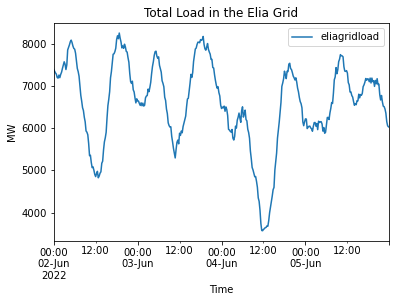

In [76]:
df_grid_load = get_open_data_elia_df("ods003", "2022-06-02", "2022-06-05")
df_grid_load = df_grid_load.loc[:,["datetime", "eliagridload"]]
#df_ts.set_index("datetime", inplace=True)
df_grid_load.plot(
    x = df_grid_load.columns[0],
    y = df_grid_load.columns[1],
    title = "Total Load in the Elia Grid",
    ylabel = "MW",
    xlabel = "Time"
)

<Response [200]>


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce1c63a4f0>,
      dtype=object)

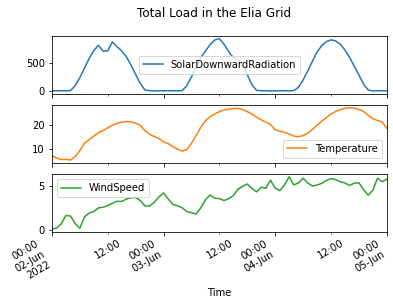

In [84]:
df_weather = get_weather_forecast("2022-06-02", "2022-06-05", latitude = "50.85045", longitude = "4.34878")
#df_weather = df_weather.loc[:,["datetime", "eliagridload"]]
#df_ts.set_index("datetime", inplace=True)
df_weather.plot(
    x = df_weather.columns[0],
    y = [df_weather.columns[1],df_weather.columns[2],df_weather.columns[3]],
    title = "Total Load in the Elia Grid",
    xlabel = "Time",
    subplots = True
)

## 2. Timeseries Forecasting with Prophet (Facebook)

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets.
It is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

**Documentation:** https://facebook.github.io/prophet/docs/quick_start.html

### 2.1 Univariate Forecasting

#### Installation of Prophet

In [88]:
pip install pystan==2.19.1.1

  Using cached pystan-2.19.1.1-cp38-cp38-manylinux1_x86_64.whl (62.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [89]:
pip install prophet

  Using cached prophet-1.0.1.tar.gz (65 kB)
  Using cached cmdstanpy-0.9.68-py3-none-any.whl (49 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
     |████████████████████████████████| 179 kB 13.9 MB/s eta 0:00:01
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached ujson-5.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
  Using cached ephem-4.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
Processing /home/jovyan/.cache/pip/wheels/a0/8b/b2/810ae5a6f970c8be4725353400d643c90de1c0f023a9884ee7/PyMeeus-0.5.11-py3-none-any.whl
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-f1epejno/prophet/setup.py'"'"'; __f

In [ ]:
## for Anaconda 
#conda install -c conda-forge prophet

Dont forget to restart the kernel.

#### Setup and Training of Prophet

In [87]:
from prophet import Prophet

def run_forecast_univariate(df, periods):

    #renaming columns for prophet convention
    df = df.rename(columns = {df.columns[0]: "ds", df.columns[1]:"y"})

    # creating a Prophet object 
    ## optional parameters can be set here like:
    ## seasonality, changepoints, uncertainty intervals etc. see help(Prophet) 
    ## e.g. weekly_seasonality = True
    m = Prophet() 

    # fit() methods expects a dataframe with the column heads ds and y
    # fits the prophet model to the data
    m.fit(df)

    # Definition of forecast range
     ## periods: Int number of periods to forecast forward. 
     ## req: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    future = m.make_future_dataframe(periods=periods, freq = "H")
    
    # Prediction
     ## expects a dataframe with dates for predictions 
     ## (created above with make_future_dataframe)
    forecast = m.predict(future)
    
    # plotting
    fig_forecast = m.plot(forecast)
    fig_comp = m.plot_components(forecast)
    
    return forecast, fig_forecast, fig_comp

ModuleNotFoundError: No module named 'prophet'

**Test Univariate Forecast**

In [86]:
df_grid_load = get_open_data_elia_df("ods003", "2022-06-02", "2022-06-05")
forecast, fig_forecast, fig_comp = run_forecast_univariate(df_grid_load, 100)
forecast, fig_forecast, fig_comp

NameError: name 'run_forecast_univariate' is not defined

#### Multivariate Forecasting

In [ ]:
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from datetime import timedelta
import pandas as pd

from prophet.utilities import regressor_coefficients
from modules.fetch_data import get_weather_forecast, get_open_data_elia_df


def prepare_data_for_mv_fc(dataset, start_date, end_date, solar, wind, temp, lat,long):
    """
    Prepares and merges data for Wind and PV multivariate forecast

    Parameters
    ----------
    dataset: str
        the selected dataset identifier from the Elia Open Data Platform
    start_date: str
        The start date of the selected dataset, Format: "YYYY-MM-DD"
    end_date: str
        The end date of the selected dataset, Format: "YYYY-MM-DD"    
    solar: bool
        if True, solar data will be added as additional regressor
    wind: bool
        if True, wind data will be added as additional regressor
    temp: bool
        if True, temp data will be added as additional regressor
    lat: str
        The latitude value (Geo location) of the city for the weather forecast
    long: str
        The longitude value (Geo location) of the city for the weather forecast

    Returns
    -------
    pd.Dataframe
        a dataframe containing the selected data
    
    """
    # catch open data
    if (dataset == "ods003"): # total load
        df = get_open_data_elia_df(dataset,start_date, end_date) 
        df.set_index(df["datetime"], inplace = True)
        df = df.resample("H").mean()
        df.reset_index(inplace = True)
        
    else:  # for solar & wind 
        df = get_open_data_elia_df(dataset,start_date, end_date) 
        df = df.groupby("datetime").sum()
        df = df.resample("H").mean()
        df.reset_index(inplace = True)
        df = df.loc[:,["datetime", "mostrecentforecast"]]
        df["datetime"] = pd.to_datetime(df["datetime"]).dt.tz_localize(None)

    # specifying variables
    start_date= df["datetime"].iloc[0]
    end_date = df["datetime"].iloc[-1]
    latitude = lat
    longitude = long

    # get weather forecast
    df_weather = get_weather_forecast(start_date, end_date, latitude, longitude)
    columns = []
    if solar:
        columns.append("SolarDownwardRadiation")
    if wind:  
        columns.append("WindSpeed")
    if temp:
        columns.append("Temperature")

    columns.append("datetime")
    df_weather = df_weather.loc[:,columns]    
    df_merged = merge_df_with_add_reg(df, df_weather, "datetime", "datetime")
    df_merged.rename(columns = {df.columns[0]: "ds", df.columns[1]:"y"}, inplace = True)

    return df_merged



In [ ]:
def merge_df_with_add_reg(df1, df2, left_on, right_on):
    df = df1.merge(df2, left_on= left_on, right_on = right_on)
    return df

In [ ]:
def run_forecast_multivariate(df_merged, lat, long, forecast_horizon):

    end_date = df_merged["ds"].sort_values().iloc[-1]
    logger.debug(df_merged["ds"].sort_values())
    start_date_forecast = end_date + timedelta(hours = 1)
    end_date_forecast = start_date_forecast + timedelta(hours = forecast_horizon)
    weather_forecast = get_weather_forecast(start_date_forecast, end_date_forecast, lat, long)

    m = Prophet(yearly_seasonality=True) 
    
    for each in df_merged.columns[2:]:
        m.add_regressor(each)

    # fit() methods expects a dataframe with the column heads ds and y
    # fits the prophet model to the data
    m.fit(df_merged)

    # Definition of forecast range
    ## periods: Int number of periods to forecast forward. 
    ## req: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    future = m.make_future_dataframe(periods=forecast_horizon, freq = "H")
    future = merge_df_with_add_reg(future, weather_forecast, left_on = "ds", right_on="datetime")

    # Prediction
    ## expects a dataframe with dates for predictions 
    ## (created above with make_future_dataframe)
    forecast = m.predict(future)

    # plotting
    fig_forecast = m.plot(forecast)
    fig_components = m.plot_components(forecast)

    reg_coef = regressor_coefficients(m)
    
    return forecast, fig_forecast, fig_components, reg_coef


**Bringing everything together in a forecasting function**

**Test the forecast function**

In [ ]:
# import of budget timeserie as dataframe
# rename dataframe to prophet convention: 

df = get_open_data_elia_df(total_load_dataset,1000) 
df_ts = df.loc[:,["datetime", "eliagridload"]]
df_ts.rename(columns = {df_ts.columns[0]: "ds", df_ts.columns[1]:"y"}, inplace = True)
forecast_prophet(df_ts, 72)

In [432]:
yhat = trend + yearly + extra_regressors_additive,
where
extra_regressors_additive = (temperature_data - temperature_center)*temperature_coef 
                            + (humidity_data - humidity_center )* humidity_coe

NameError: name 'prophet' is not defined